# Coffee Disease Classification using DenseNet Transfer Learning with TensorFlow
In this notebook, we'll be implementing DenseNet transfer learning model for a coffee disease classification with TensorFlow. This computer vision project aims to classify different types of coffee diseases using a pre-trained DenseNet model with TensorFlow. The project involves using a transfer learning approach where the pre-trained DenseNet model is fine-tuned on a dataset of coffee disease images to classify 5 different types of coffee diseases. The project involve data preprocessing using TensorFlow's image data generators, splitting the data into training and validation sets, implementing early stopping to prevent overfitting, and using checkpointing to save the model's progress. The final output of the project would be a trained model that can accurately classify the different types of coffee diseases.

## Install and import TensorFlow libraries
We will start by ensuring that we have the latest version of the TensorFlow package installed and importing the Tensorflow libraries we're going to use.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
from  tensorflow import keras
print('TensorFlow version:',tf.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.11.0
Keras version: 2.11.0


In [3]:
# Load relevant libraries
# load and check images for errors
import PIL
from PIL import Image
import os

# For image manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Preprocess data

For us to use transfer learning, we will need a base model from which we can use the trained feature extraction layers. The DenseNet model is a CNN-based image classifier that has been pre-trained using a huge dataset of 3-color channel images of 224x224 pixels. Let's create an instance of it with some pretrained weights, excluding its final (top) prediction layer.

To prevent training interruption due to corrupt images, the code below intends to identify and delete corrupted images in each of the specified folders. It uses the PIL library to attempt opening each image file in the folders. If an image file raises the "UnidentifiedImageError" exception, it means the image file is corrupt, and the code removes the file from the folder. The code also helps to ensure that only valid image files are used in the image classification process, which can improve the accuracy of the trained model.

In [3]:
# # Identify and delete corrupted image in each of the folder file
# folder_paths = [
#     '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/data/Healthy',
#     '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/data/Cerscospora',
#     '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/data/Leaf rust',
#     '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/data/Miner',
#     '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/data/Phoma'
# ]

# for folder_path in folder_paths:
#   for filename in os.listdir(folder_path):
#       try:
#           image = Image.open(os.path.join(folder_path, filename))
#       except PIL.UnidentifiedImageError as e:
#           print(f"Error in file {filename}: {e}")
#           os.remove(os.path.join(folder_path, filename))
#           print(f"Removed file {filename}")

Now, we will go ahead to load and prepare the coffee disease classification dataset for training and validation using `ImageDataGenerator` from the `keras.preprocessing.image` module. The dataset will be loaded from our directory and split into training and validation subsets with 70% and 30% of the data respectively. We will also set the target size of the images to 224 x 224 of 32, and the class mode is set to categorical since we have multiple classes to predict. Finally, the code prints out the class names in the dataset.

In [4]:
# Load the data
data_dir = '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/data'
batch_size = 32
img_height = 224
img_width = 224

print("Getting data...")
# Create a data generator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3)

# Load the data from the directory
print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting data...
Preparing training dataset...
Found 41008 images belonging to 5 classes.
Preparing validation dataset...
Found 17571 images belonging to 5 classes.
class names:  ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']


## Train our model with the inclusion of a checkpoint
Firstly, let's create our DenseNet model with pre-trained weights on the ImageNet dataset. The pre-trained model is used as the feature extractor with the final layers added for classification. The last layer will use a softmax activation function to output the probabilities of each class. The model is also frozen to prevent the weights from being updated during the initial training.

In [5]:
# Create a DenseNet model
model = keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3))

# Freeze the layers
model.trainable = False

# Add the final layers
x = model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(5, activation='softmax')(x)

# Create the model
model = keras.models.Model(inputs=model.input, outputs=predictions)

29084464/29084464 [==============================] - 0s 0us/step


Now is time to train our model. We will do few things next while we go ahead to train our coffee image disease classifier, while we use some callbacks. Here are the main steps:

- Set up some parameters like the checkpoint directory, latest checkpoint, and the number of epochs.
- Check if there is an existing checkpoint and history file, and load them if they exist.
- Create several callbacks, including a ModelCheckpoint callback to save the model at the end of every epoch to allow us continue from where we stopped in case of any interruption, a CSVLogger to log the training progress, a ReduceLROnPlateau callback to reduce the learning rate if the validation loss stops improving, and an EarlyStopping callback to stop training if the validation loss doesn't improve for a certain number of epochs.
- Compile the model with an optimizer, loss function, and metrics.
- Train the model using the fit() method with the training and validation generators, the initial epoch, and the callbacks. The history of the training is returned as a history_callback object

In [6]:
# Define the paths
checkpoint_dir = "/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint"
latest_checkpoint = "/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/densenet_model09_1.0000.hdf5"
epochs = 10

# Check if there is an existing checkpoint and history
if os.path.exists(checkpoint_dir):
  model.load_weights(latest_checkpoint)
  history_file = "/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/history.csv"
  history_df = pd.read_csv(history_file)
  initial_epoch = history_df["epoch"].iloc[-1] + 1
  print(f"Loaded history from {history_file}, and will continue training next epoch after {initial_epoch}")
else:
  initial_epoch = 0
  print(f"No history file found at {history_file}, starting training from epoch 1")

# Create callbacks
checkpoint_callback = ModelCheckpoint(
    os.path.join(checkpoint_dir, "densenet_model{epoch:02d}_{val_accuracy:.4f}.hdf5"),
    save_best_only=False,
    save_weights_only=False, # Save the entire model, not just the weights
    monitor="val_accuracy",
    mode="max",
    save_freq='epoch',
    verbose=1
)

csv_logger_callback = CSVLogger("/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/history.csv", append=True)

reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    mode="min",
    min_delta=0.0001
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

# Train the model
history_callback = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    initial_epoch=initial_epoch,
    callbacks=[checkpoint_callback, csv_logger_callback, reduce_lr_callback, early_stopping_callback]
)

Loaded history from /content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/history.csv, and will continue training next epoch after 9
Epoch 10/10
1281/1281 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9993
Epoch 10: saving model to /content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/densenet_model10_1.0000.hdf5
1281/1281 [==============================] - 11094s 9s/step - loss: 0.0054 - accuracy: 0.9993 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010


Based on the result above, after training over 10 epochs, our model achieved the following results:

- Training loss of 0.0054: This means that on average, the model's predictions were only off by a very small amount from the actual values in the training set.
- Training accuracy of 0.9993: This means that the model was able to correctly classify almost all of the images in the training set.
- Validation loss of 0: This means that the model's predictions were exactly correct for all images in the validation set.
- Validation accuracy of 1: This means that the model was able to correctly classify all of the images in the validation set.
- Learning rate of 0.001: This is the rate at which the optimizer is adjusting the weights of the model during training. In this case and from observation of previous epoch, the learning rate remained constant throughout training.

Overall, the results suggest that the model has achieved a high level of accuracy and is likely performing well on the task of coffee disease classification.

## Evaluating our Trained DenseNet Model

We will start by plotting the training and validation accuracy as well as the training and validation loss during the training process of our deep learning model. We will be using the `history.csv` file saved with our `CSVLogger` callback during our training process, which contains the training and validation accuracy and loss values at each epoch. We will create a figure with 2x2 subplots, where the first subplot shows the training and validation accuracy and the second subplot shows the training and validation loss.

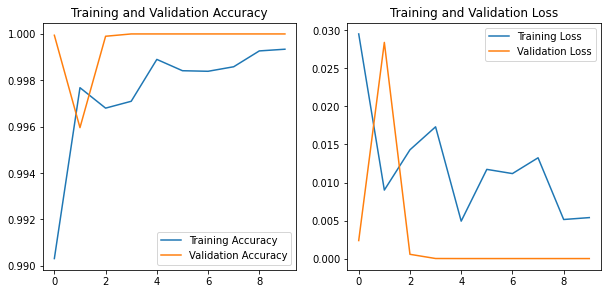

In [7]:
# Plot the accuracy and loss
history = pd.read_csv("/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/history.csv")
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The chart above shows that our training accuracy kept improving up till the last epoch, however, our validation accuracy remained sustained at 1.0 from the 4th epoch. On the other hand our training loss decreased up till the last epoch even though with some slight irregularity, but within the range of 0.005 and 0.015, which still shows our model significantly classify almost all the images in our training set. The validation loss however, remained 0 at epoch 9 and 10.

In [5]:
# load our best model from checkpoint
best_checkpoint_path = '/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Checkpoint/densenet_model10_1.0000.hdf5'
model = keras.models.load_model(best_checkpoint_path)

In [41]:
# Get a random batch of validation data
x_val, y_val = validation_generator.next()
classnames = list(validation_generator.class_indices.keys())

# Make predictions on the batch of validation data
preds = model.predict(x_val)

# Get the predicted and true label for each image in the batch
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_val, axis=1)

1/1 [==============================] - 5s 5s/step


Text(0.5, 117.59999999999997, 'Predicted')

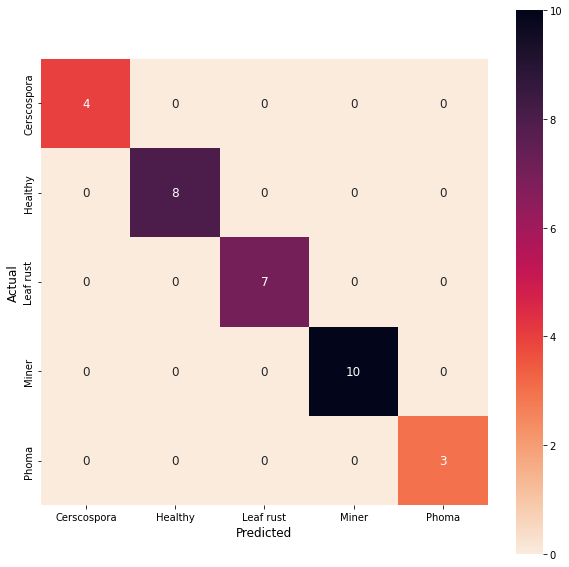

In [42]:
# Plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".0f",annot_kws={'size':12},
                 annot=True, 
                 square=True, 
                 xticklabels=classnames, 
                 yticklabels=classnames)
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

In [43]:
# Compute the evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')

# Print the evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 score: {:.4f}".format(f1))

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000


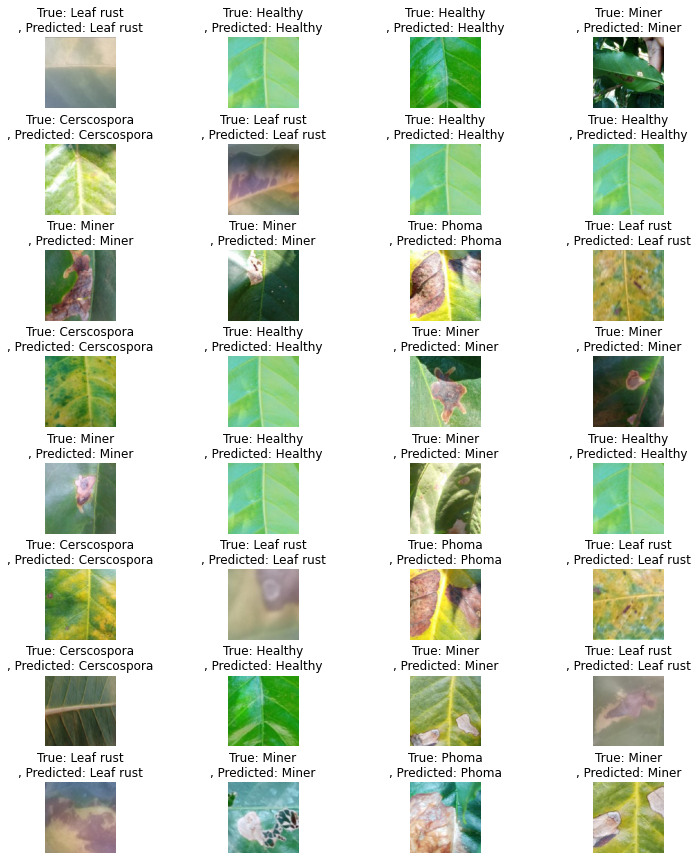

In [46]:
# Plot the images and their labels
num_pred = 32
nrows = 8
ncols = 4
fig, axes = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12, 15))
axes = axes.ravel()

for i in np.arange(0, num_pred):
    axes[i].imshow(x_val[i])
    axes[i].set_title(f"True: {classnames[true_labels[i]]}\n, Predicted: {classnames[pred_labels[i]]}")
    axes[i].axis('off')
    
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [17]:
# Save the final model
model.save('/content/drive/MyDrive/DS-ML projects/Coffee Disease Classification/Model/final_coffee_disease_densenet_model.h5')